In [1]:
import os
import time
import logging
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from benchmarks.map_benchmark import Mix3ToMix10Benchmark
from benchmarks import distributions
from lib.act_func import Activations
from lib.hjbflow import ICNN1,ICNN3,train_flow,evaluation_benchmark_ode,evaluation_straight
from lib.loss_func import compute_loss,compute_loss_back
import torch.nn.functional as F
from tqdm import tqdm


In [2]:
num_samples  = 1024
iterations   = 50000
batch_size   = 1024 # 
lr           = 1e-3
dim          = 2
dimh         = 1024
num_layers   = 12
act_name     = 'ssp'
act_fn       = Activations.get_act(act_name)
log_interval = 20
vis_interval = 1000  

In [3]:
log_dir = "./results/benchmark"
os.makedirs(log_dir, exist_ok=True)
logging.basicConfig(
    filename=os.path.join(log_dir, "train_i3new_back_dim"+str(dim)+".log"),
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s"
)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

In [5]:
benchmark = Mix3ToMix10Benchmark(dim,device=device)

/home/sfh/ICNNFlow-new/benchmarks/map_benchmark.py:210: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(
/home/sfh/ICNNFlow-new/benchmarks/map_benchmark.py:223: Fut

In [6]:
#  num_samples from benchmark as training data
x0_list, x1_list = [], []
cnt0 = cnt1 = 0
# input
while cnt0 < num_samples:
    batch = benchmark.input_sampler.sample(batch_size)
    x0_list.append(batch)
    cnt0 += batch.size(0)
# output 
while cnt1 < num_samples:
    batch = benchmark.output_sampler.sample(batch_size)
    x1_list.append(batch)
    cnt1 += batch.size(0)

x0_full = torch.cat(x0_list, dim=0)[:num_samples].to(device)
x1_full = torch.cat(x1_list, dim=0)[:num_samples].to(device)

print("Loaded benchmark samples:", x0_full.shape, x1_full.shape)
logging.info(f"Loaded benchmark samples: x0={x0_full.shape}, x1={x1_full.shape}")

Loaded benchmark samples: torch.Size([1024, 2]) torch.Size([1024, 2])


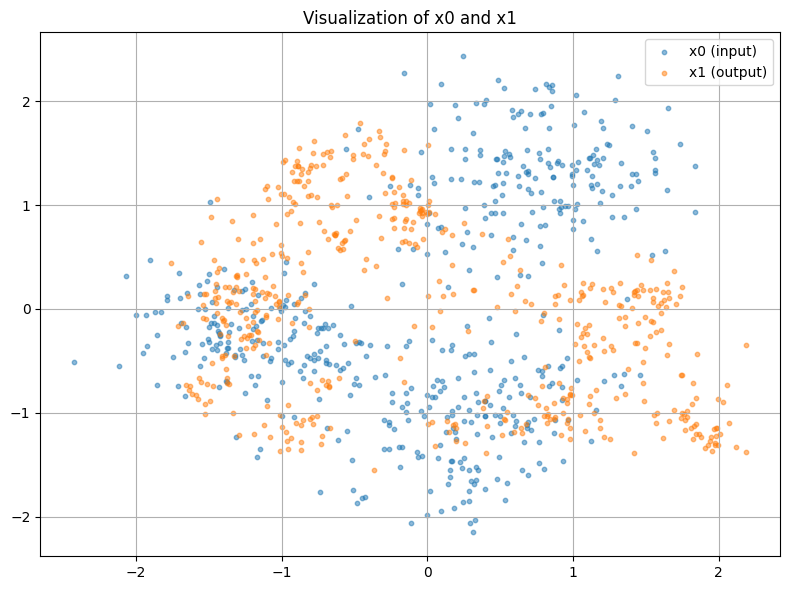

In [7]:
x0_np = x0_full[:512].cpu().numpy()
x1_np = x1_full[:512].cpu().numpy()

data_all = np.vstack([x0_np, x1_np])
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_all)

x0_2d = data_2d[:len(x0_np)]
x1_2d = data_2d[len(x0_np):]

plt.figure(figsize=(8, 6))
plt.scatter(x0_2d[:, 0], x0_2d[:, 1], alpha=0.5, label='x0 (input)', s=10)
plt.scatter(x1_2d[:, 0], x1_2d[:, 1], alpha=0.5, label='x1 (output)', s=10)
plt.legend()
plt.title("Visualization of x0 and x1")
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
model = ICNN3(
    dim=dim,
    dim_t=1,
    dimh=dimh,
    num_hidden_layers=num_layers,
    act_fn=act_fn,
    batch_size=batch_size
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [9]:
def train_identity_map(D, sampler, batch_size=1024, max_iter=5000, lr=1e-3, tol=1e-3, blow=3,  device= torch.device("cuda:1")):
    "Trains potential D to satisfy D.push(t,x)=x by using MSE loss w.r.t. sampler's distribution"
    opt = torch.optim.Adam(D.parameters(), lr=lr, weight_decay=1e-10)
    print('Training the potentials to satisfy push(x)=x')
    pbar = tqdm(range(max_iter))
    for iteration in pbar:
        X = sampler.sample(batch_size).to(device)
        t = torch.rand(batch_size, 1, device=X.device)
        # t1 = torch.ones(batch_size,1,device = X.device)
        with torch.no_grad():
            X *= blow
        X.requires_grad_(True)

        loss = F.mse_loss(D.gradx(X,t), X.detach())
        # loss = F.mse_loss(torch.sum(D(X,t),dim=1), torch.sum(X.pow(2)/2.0,dim=1).detach())
        loss.backward()
        opt.step(); opt.zero_grad()
        pbar.set_description(f" loss {loss:.4f}")

        if loss.item() < tol:
            break
            
    loss = loss.item()
    torch.cuda.empty_cache()
    return loss

# pretrain_sampler = distributions.StandardNormalSampler(dim=dim)
# train_identity_map(model, pretrain_sampler, blow=3,device = device)


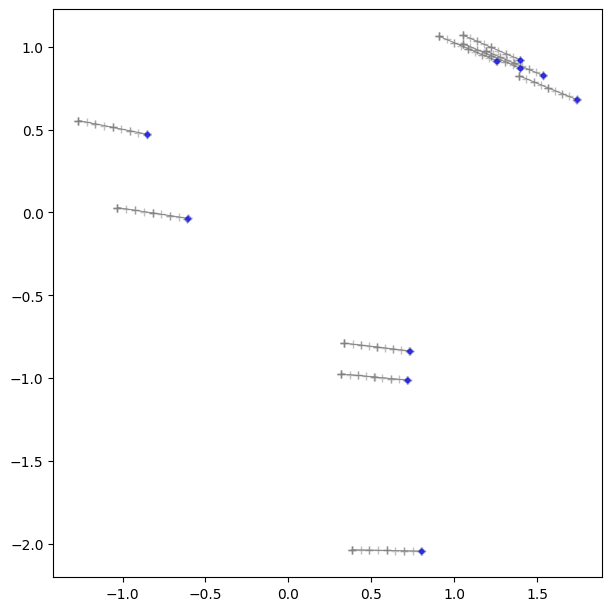

In [10]:
loss_history = []
start_time = time.time()

Xsampler = benchmark.input_sampler
Ysampler = benchmark.output_sampler

traj=evaluation_straight(model,benchmark.input_sampler)

In [11]:
chunk = 5000            
os.makedirs(log_dir, exist_ok=True)
checkpoint_path = os.path.join(log_dir, f"checkpoint_i3new_back_dim{dim}.pth")


start_iter = 0
loss_history = []
if os.path.exists(checkpoint_path):
    ck = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ck['model_state'])
    optimizer.load_state_dict(ck['optimizer_state'])
    start_iter = ck.get('iteration', 0) + 1
    loss_history = ck.get('loss_history', [])
    print(f"from iter {start_iter} continue，loss_history: {len(loss_history)}")
else:
    print("Begin")

current_iter = start_iter

try:
    while current_iter < iterations:
        this_chunk = min(chunk, iterations - current_iter)
        print(f"train iter {current_iter} to {current_iter + this_chunk - 1}")
        loss_seg = train_flow(
            model, optimizer,
            Xsampler, Ysampler,
            iterations=this_chunk,
            batch_size=batch_size,
            loss_func=compute_loss_back,
            log_interval=log_interval,
            benchmark=benchmark,
            minibatch=True,
        )
        
        loss_history.extend(loss_seg)
        current_iter += this_chunk

        # save checkpoint
        torch.save({
            'iteration': current_iter - 1,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'loss_history': loss_history,
            'hyperparams': {
                'dim': dim,
                'num_hidden_layers': num_layers,
                'dimh': dimh,
                'activation': act_name,
                'batch_size': batch_size,
                'lr': lr,
            },
            'model_name': model.__class__.__name__,
            'model_structure': str(model),
        }, checkpoint_path)
        print(f"已保存 checkpoint 到 iter {current_iter - 1}")
    print("全部迭代完成")
except KeyboardInterrupt:
    torch.save({
        'iteration': current_iter - 1,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'loss_history': loss_history,
    }, checkpoint_path)
    print(f"检测到中断，已保存 checkpoint 到 iter {current_iter - 1}")
    raise


从头开始训练
训练 iter 0 到 4999


FM 0.0160, HJ 0.0001, UVP 1.0031: 100%|█████████████████████████████████████████████| 5000/5000 [15:43<00:00,  5.30it/s]


已保存 checkpoint 到 iter 4999
训练 iter 5000 到 9999


FM 0.0214, HJ 0.0002, UVP 0.4733:  35%|███████████████▊                             | 1757/5000 [05:48<10:23,  5.20it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



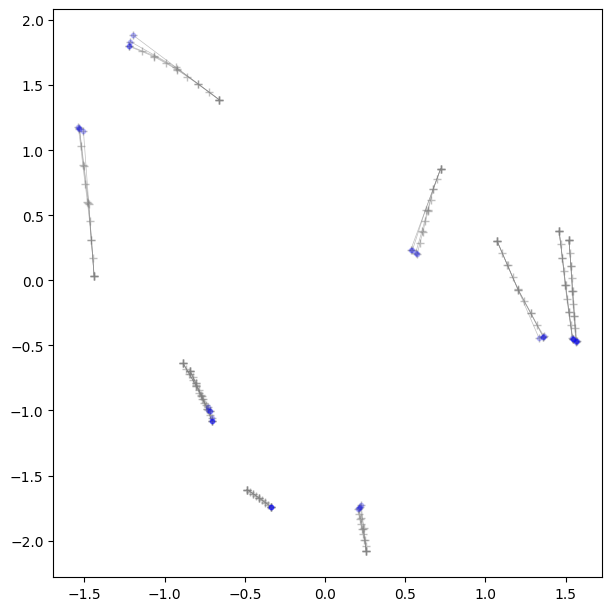

In [12]:
traj=evaluation_straight(model,benchmark.input_sampler)

In [13]:
device = next(model.parameters()).device
test_size = 4096
x_0 =Xsampler.sample(test_size)
x_1 = Ysampler.sample(test_size)
t = torch.rand(test_size, 1, device=device)*0+0.95
l=compute_loss(model,x_1,x_0,t)

In [14]:
l[2]

tensor(2.0366e-06, device='cuda:0', grad_fn=<MeanBackward0>)

L2-UVP forward (% of variance): 0.7489


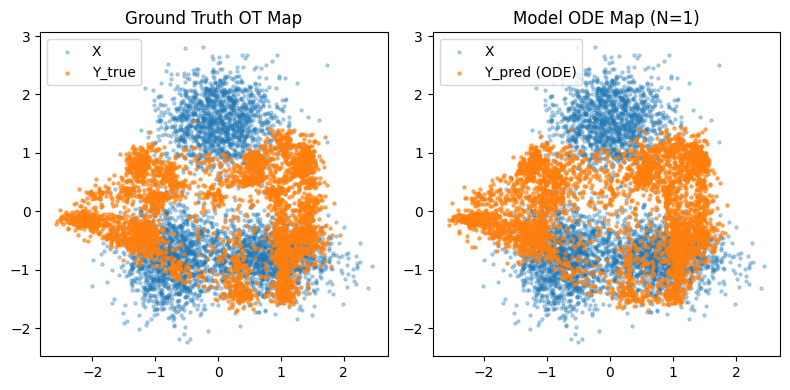

In [15]:
model.eval()
fig,L2_UVP_fwd=evaluation_benchmark_ode(
    model=model,      
    prior_sampler=benchmark.input_sampler,
    target_sampler=benchmark.output_sampler,
    log_dir=log_dir,
    benchmark=benchmark,
    num_display=4096,
    N_steps=1,       
)
fig.savefig(os.path.join(log_dir, "dim"+str(dim)+"_i3new_back_result.png"))
print(f"L2-UVP forward (% of variance): {L2_UVP_fwd:.4f}")

In [16]:
train_time = time.time() - start_time
logging.info(f"Training completed in {train_time:.2f} seconds")

plt.figure()
plt.plot(loss_history)
plt.title("Training Loss on Benchmark")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.yscale('log')
plt.tight_layout()
plt.savefig(os.path.join(log_dir, "loss_benchmark_i3new_back_dim"+str(dim)+".png"))
plt.close()

In [17]:
loss_history

[0.3868847191333771,
 1.8047196865081787,
 0.49549800157546997,
 0.5692863464355469,
 0.8499839305877686,
 0.7070996761322021,
 0.48368072509765625,
 0.394963800907135,
 0.30408361554145813,
 0.3306736946105957,
 0.3598135709762573,
 0.3792780041694641,
 0.38375571370124817,
 0.37684816122055054,
 0.36851125955581665,
 0.34745916724205017,
 0.31534427404403687,
 0.30160656571388245,
 0.28801271319389343,
 0.28599241375923157,
 0.2954466938972473,
 0.2969510853290558,
 0.31900086998939514,
 0.31095027923583984,
 0.2818065285682678,
 0.26698753237724304,
 0.2639014720916748,
 0.2699314057826996,
 0.2682424783706665,
 0.2580927610397339,
 0.27967944741249084,
 0.26712772250175476,
 0.25673094391822815,
 0.2374953180551529,
 0.2541664242744446,
 0.24879249930381775,
 0.25209009647369385,
 0.2337147444486618,
 0.22672536969184875,
 0.24659165740013123,
 0.23702916502952576,
 0.220854252576828,
 0.29931309819221497,
 0.23075397312641144,
 0.24180281162261963,
 0.21423088014125824,
 0.2167158

In [18]:
# torch.save({
#     'model_state': model.state_dict(),
#     'optimizer_state': optimizer.state_dict(),
#     'hyperparams': {
#         'dim': dim,
#         'num_hidden_layers': num_layers,
#         'dimh': dimh,
#         'activation': 'ssp',
#         'batch_size': batch_size,
#         'lr': lr,
#     },
#     'model_name': model.__class__.__name__,
#     'model_structure': str(model),
# }, os.path.join(log_dir, "checkpoint_i3new_back_dim"+str(dim)+".pth"))

#save config
config_path = os.path.join(log_dir, "train_config_i3new_back_dim"+str(dim)+".txt")
with open(config_path, "w") as f:
    f.write("Training configuration:\n")
    f.write(f"Device: {device}\n")
    f.write(f"Num samples: {num_samples}\n")
    f.write(f"Iterations: {iterations}\n")
    f.write(f"Batch size: {batch_size}\n")
    f.write(f"dim: {dim}\n")
    f.write(f"Learning rate: {lr}\n")
    f.write(f"Hidden layers: {num_layers}\n")
    f.write(f"Hidden dim: {dimh}\n")
    f.write(f"Activation function: {act_fn}\n")
    f.write(f"Log interval: {log_interval}\n")
    f.write(f"Vis interval: {vis_interval}\n")
    f.write(f"L2-UVP forward (% of variance): {L2_UVP_fwd:.4f}")
    f.write(f"Total training time: {train_time:.2f} seconds\n")
logging.info(f"Saved training config to {config_path}")